In [5]:
import numpy as np
import random

file_path = r"C:\Users\dell\Desktop\MyDocs\Docs\MK\1661-0.txt"

# Try opening the file with 'utf-8' encoding
with open(file_path, "r", encoding="utf-8") as file:
    raw_text = file.readlines()

In [6]:
merged_text = " ".join(raw_text)

# Optional: Strip extra spaces and normalize spacing
merged_text = merged_text.replace("\n", " ").replace("\r", " ").strip()
merged_text = " ".join(merged_text.split())  # Ensure single spacing

merged_text = merged_text[1171:]
merged_text = merged_text.replace('“', '')
merged_text = merged_text.replace('”', '')
merged_text = merged_text.replace('-', ' ')
merged_text = merged_text.replace('_', ' ')

In [7]:
import re
# sentences = merged_text 
sentences = re.split(r'(?<=[.!?])\s+', merged_text.strip())

In [8]:
sentences = sentences[:10]

print(len(sentences))

10


In [9]:
sentences = [re.sub(r'(\w)([.,!?;:])', r'\1 \2', sentence) for sentence in sentences]

In [10]:
import gensim.downloader as api

# takes 3-10 minutes to load
wv = api.load('word2vec-google-news-300')

[======================----------------------------] 46.0% 764.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.2% 1266.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.3% 1500.9/1662.8MB downloaded

In [11]:
ready_sentences = []
for sentence in sentences:
    # Loại bỏ dấu câu trước khi tách từ
    clean_sentence = re.sub(r'[^\w\s]', '', sentence)
    ready_sentences.append(clean_sentence.split())

In [12]:
def create_training_data(sentences):
    data = []
    
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if word in wv]
        if len(filtered_sentence) < 6:  
            continue
        
        for end in range(5, len(filtered_sentence) - 1):
            input_seq = filtered_sentence[:end]
            target_word = filtered_sentence[end]
            
            input_ = [np.array(wv[word]).reshape(300, 1) for word in input_seq]
            target_ = np.array(wv[target_word]).reshape(300, 1)
            
            data.append((input_, target_))
    return data


training_data = create_training_data(ready_sentences)

In [13]:
print(len(training_data))

99


In [14]:
def softmax(xs):
    return np.exp(xs) / np.sum(np.exp(xs), axis=0)
def calculate_mse(out, target_word):
    mse = np.mean((out - target_word) ** 2)
    return mse

class RNN:
    def __init__(self, input_size, output_size, hidden_size=512):
        self.Whh = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wxh = np.random.randn(hidden_size, input_size) / 1000
        self.Why = np.random.randn(output_size, hidden_size) / 1000
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        # h = embedded_words[1][1] 
        h = np.zeros((self.Whh.shape[0], 1))
        # print(h.shape)
        self.last_inputs = inputs
        self.last_hs = {0: h}
        for i, x in enumerate(inputs):  
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            # print(h.shape)
            self.last_hs[i + 1] = h
        y = self.Why @ h + self.by
    
        return y, h

    def backprop(self, d_y, learn_rate=2e-2):
        n = len(self.last_inputs)
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)
        d_h = self.Why.T @ d_y
        for t in reversed(range(n)):
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
            d_bh += temp
            d_Whh += temp @ self.last_hs[t].T
            d_Wxh += temp @ self.last_inputs[t].T
            d_h = self.Whh @ temp
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            d[:] = np.clip(d, -1, 1)
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

rnn = RNN(300, 300)

import matplotlib.pyplot as plt

loss_history = [] 

def train_rnn(data, epochs=1):
    global loss_history
    for epoch in range(epochs):
        loss = 0
        cnt = 1
        for input_words, target_word in data:
            out, _ = rnn.forward(input_words)
            # if cnt == 1: 
            #     print(out)
            # probs = softmax(out)
            dot_product = np.dot(target_word.T, out)
            norm_target = np.linalg.norm(target_word)
            norm_out = np.linalg.norm(out)
            cosine_similarity = dot_product / (norm_target * norm_out)

            # Công thức gradient
            d_L_d_y= (target_word / (norm_target * norm_out)) - (dot_product * out) / (norm_target * (norm_out ** 3))
            # print(cosine_similarity)
            loss += cosine_similarity[0][0]   
            rnn.backprop(d_L_d_y)
            if cnt % 10 == 0: 
                avg_loss = loss / cnt 
                print(f"Iteration {cnt}: Current Loss = {avg_loss:.4f}")
            cnt = cnt + 1 
        avg_loss = loss / len(data)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss.item():.4f}")


train_rnn(training_data)

Iteration 10: Current Loss = -0.3069
Iteration 20: Current Loss = -0.3049
Iteration 30: Current Loss = -0.3110
Iteration 40: Current Loss = -0.3312
Iteration 50: Current Loss = -0.3302
Iteration 60: Current Loss = -0.3343
Iteration 70: Current Loss = -0.3312
Iteration 80: Current Loss = -0.3324
Iteration 90: Current Loss = -0.3409
Epoch 1, Loss: -0.3429


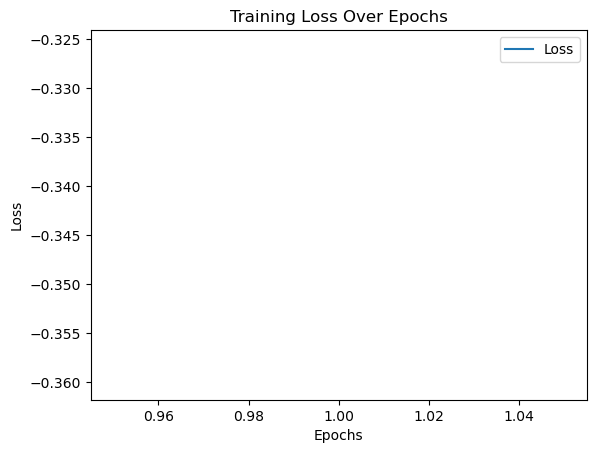

In [15]:
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [27]:
import numpy as np
import re

def predict_next_words(input_words, top_k=2):
    # Preprocess input words
    input_words = [word.replace('“', '').replace('”', '').replace('-', ' ').replace('_', ' ') for word in input_words]
    
    # Join words into a single sentence for further processing
    sentence = ' '.join(input_words)
    
    # Further clean the sentence using regex
    sentence = re.sub(r'(\w)([.,!?;:])', r'\1 \2', sentence)  # Adds space before punctuation
    
    # Split the sentence into words (tokens)
    words = sentence.split()

    # Now, assuming `wv` is a word2vec model (word embeddings) and `rnn` is an RNN model
    # You need to convert words to embeddings (e.g., using word2vec or any embeddings)
    input_embeddings = [np.array(wv[word]).reshape(300, 1) for word in words if word in wv]  # Ensure words exist in `wv`
    
    if len(input_embeddings) == 0:
        raise ValueError("None of the input words were found in the vocabulary.")
    
    # Pass word embeddings through the RNN model
    out, _ = rnn.forward(input_embeddings)  # Assuming `rnn.forward()` returns output for next word prediction
    
    mse = []  # Store Mean Squared Error for each word
    for word in wv.key_to_index:  # Use `key_to_index` to access all words in `wv`
        embedded_v = wv[word]  # Get word embedding for each word in the vocabulary
        mse_value = calculate_mse(out, embedded_v)  # You need to define `calculate_mse`
        mse.append((word, mse_value))
    
    # Sort words by MSE in ascending order
    mse_sorted = sorted(mse, key=lambda x: x[1])
    
    # Extract top_k predicted words
    predictions = [row[0] for row in mse_sorted[:top_k]]
    
    return predictions


In [ ]:
while True:
    user_input = input("Enter a sentence (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting the program. Goodbye!")
        break
    
    # Convert input sentence to a list of lowercase words
    input_words = user_input.lower().split()  # Split sentence into individual words
    
    try:
        # Pass the list of words to predict_next_words
        predicted_words = predict_next_words(input_words, top_k=2)
        
        # Print the input sentence and predicted words
        print(f"Input: {' '.join(input_words)}")
        print(f"Predicted next words: {', '.join(predicted_words)}")
        
    except KeyError as e:
        print(f"Error: {e}. Please ensure your input contains words from the vocabulary.")

Enter a sentence (or type 'exit' to quit):  It is


Input: it is
Predicted next words: AP_HOCKEY_NEWS, BY_WAYNE_PHILLIPS
